In [1]:
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../src/')
import densities, conditional
import pykalman

# Kalman filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
z_{t} = A z_{t-1} + b + \zeta_t \\
x_{t} = C z_t + d + \xi_t,
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\zeta_t \sim N(0,Q_z)\\
\xi_t \sim N(0,Q_x).
$$

In [5]:
class KalmanFilter:
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        """ This is a linear Kalman filter.
        
        :param X: numpy.ndarray [N, Dx]
            The observed data.
        :param A: numpy.ndarray [Dz, Dz]
            The state transition matrix.
        :param b: numpy.ndarray [Dz]
            The state transition offset.
        :param Qz: numpy.ndarray [Dz, Dz]
            The state covariance.
        :param C: numpy.ndarray [Dx, Dz]
            The observation matrix.
        :param d: numpy.ndarray [Dx]
            The observation offset.
        :param Qx: numpy.ndarray [Dx, Dx]
            The observation covariances. 
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditional.ConditionalGaussianDensity(numpy.array([A]), numpy.array([b]), numpy.array([Qz]))
        self.emission_density = conditional.ConditionalGaussianDensity(numpy.array([C]), numpy.array([d]), numpy.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self) -> pdf.GaussianDensity:
        """ Initializes a density object (with uniform densities).
        """
        Sigma = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        mu = numpy.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * numpy.log(numpy.ones(self.T+1))
        return pdf.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        """ Forward iteration.
        """
        for t in range(1, self.T+1):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_{1:t-1}) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        
        :param t: int
            Time index.
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice([t-1])
        # p(z_t|x_{1:t-1})
        cur_prediction_density = pre_filter_density.affine_marginal_transformation(self.state_density)
        # Write result into prediction density collection
        self.prediction_density.update([t], cur_prediction_density)
        
        
    def filtering(self, t: int):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        
        :param t: int
            Time index.
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice([t])
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = cur_prediction_density.affine_conditional_transformation(self.emission_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t-1:t])
        # Write result into filter density collection
        self.filter_density.update([t], cur_filter_density)

In [6]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .2
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)
Qx = noise_x ** 2 * numpy.eye(Dx)
Qz = noise_z ** 2 * numpy.eye(Dz)
A, b = numpy.eye(Dz), numpy.zeros((Dz,))
C, d = numpy.eye(Dx), numpy.zeros((Dx,))
kf = KalmanFilter(X, A, b, Qz, C, d, Qx)
kf.forward_path()

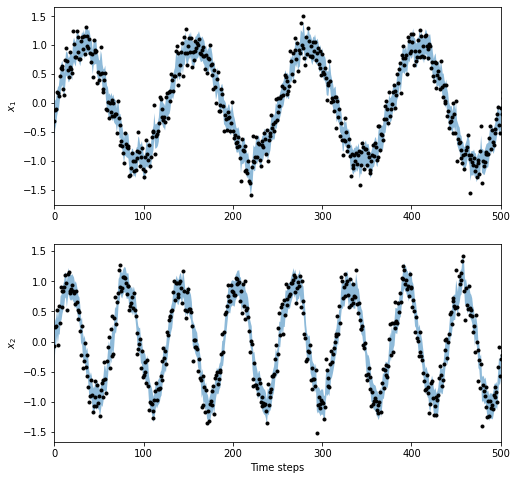

In [8]:
mean_estimate = kf.filter_density.mu
std_estimate = 1.68 * numpy.sqrt(kf.filter_density.Sigma.diagonal(axis1=1, axis2=2))

pyplot.figure(figsize=(8,8))
ax1 = pyplot.subplot(211)
pyplot.plot(X[:,0], 'k.')
pyplot.fill_between(range(T), mean_estimate[1:,0] - std_estimate[1:,0], mean_estimate[1:,0] + std_estimate[1:,0], alpha=.5)
pyplot.xlim([0,500])
pyplot.ylabel('$x_1$')
pyplot.subplot(212, sharex=ax1)
pyplot.plot(X[:,1], 'k.')
pyplot.fill_between(range(T), mean_estimate[1:,1] - std_estimate[1:,1], mean_estimate[1:,1] + std_estimate[1:,1], 
                    alpha=.5)
pyplot.xlabel('Time steps')
pyplot.ylabel('$x_2$')
pyplot.show()